In [1]:

import os
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from statistics import mean


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cuda


In [3]:
# Base Directory defined.
base_dir = 'I:\\ML\\Projs\\videoclass\\data'

# Train and Validation directory Defined.
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')


In [4]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(30),
                                      transforms.Resize(255),
                                      transforms.CenterCrop(299),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(299),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])


#arranges the data into suitable structured format for torch to recognise and load in
train_data = datasets.ImageFolder(train_dir, transform= train_transform)
test_data = datasets.ImageFolder(test_dir, transform= test_transform)

#Defining dataloaders with everything attached.
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

In [5]:
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [6]:
#freeze model parameters
for params in model.parameters():
    params.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 1024),
                     nn.ReLU(),
                     nn.Dropout(p=0.5),
                     nn.Linear(1024, 512),
                     nn.ReLU(),
                     nn.Dropout(p=0.2),
                     nn.Linear(512, 2),
                     nn.LogSoftmax(dim=1))


#loss criterion and optimiser 
criterion = nn.NLLLoss()
optimiser = optim.Adam(model.parameters(), lr=0.003)

#move model to GPU or CPU according to their availability.
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [9]:
traininglosses= []
testinglosses= []
testaccuracy= []
totalsteps= []

a=0

epochs = 1
steps = 0
runn = 0
print_every = 5

for epoch in range(epochs):
    for images, labels in trainloader:
        steps += 1
        
        images, labels = images.to(device), labels.to(device)  #pushing training data onto device
        
        optimiser.zero_grad() #erasing preexisting gradients in a classifier
        
        logps = model(images) #extracting initial predictions
        loss = criterion(logps, labels) #calculating initial loss
        loss.backward() #backpropagates calculated gradients
        
        optimiser.step() #one step to update the weights
        
        runn += loss.item() #record running loss
        
        if steps % print_every == 0:
            model.eval() #model starts in evaluation mode for testing.
            test_loss = 0
            acc = 0
            
            for images, labels in testloader: 
                
                images, labels= images.to(device), labels.to(device) #push all testing data
                
                logps = model(images) #predictions for testing
                #loss = Variable(loss, requires_grad = True)
                loss = criterion(logps, labels) #test loss
                test_loss += loss.item() #updating test loss
                
                ps = torch.exp(logps) 
                top_ps, top_c = ps.topk(1, dim=1) 
                equal = top_c == labels.view(top_c.shape) #comparing top_c to actual labels to obtain the number of accurate predictions
                acc += torch.mean(equal.type(torch.FloatTensor)).item() #storing the result in acc list.
                
            traininglosses.append(runn/print_every) #running loss/ 5 to average out the loss whenever it gets used
            testinglosses.append(test_loss/len(testloader)) #total loss generated averaged with the test set size.
            testaccuracy.append(acc/len(testloader)) #total accuracy averaged with the test set size
            totalsteps.append(steps) #list containing step count as we proceed
                
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {runn/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {acc/len(testloader):.3f}")
            runn = 0
            model.train() #pushes it back to training mode

Epoch 1/1.. Train loss: 3.400.. Test loss: 0.794.. Test accuracy: 0.513
Epoch 1/1.. Train loss: 0.775.. Test loss: 0.694.. Test accuracy: 0.487
Epoch 1/1.. Train loss: 0.691.. Test loss: 0.735.. Test accuracy: 0.513
Epoch 1/1.. Train loss: 0.631.. Test loss: 0.657.. Test accuracy: 0.513
Epoch 1/1.. Train loss: 0.584.. Test loss: 0.602.. Test accuracy: 0.545
Epoch 1/1.. Train loss: 0.545.. Test loss: 0.463.. Test accuracy: 0.877
Epoch 1/1.. Train loss: 0.389.. Test loss: 0.592.. Test accuracy: 0.598
Epoch 1/1.. Train loss: 0.422.. Test loss: 0.310.. Test accuracy: 0.921
Epoch 1/1.. Train loss: 0.541.. Test loss: 0.357.. Test accuracy: 0.909
Epoch 1/1.. Train loss: 0.399.. Test loss: 0.607.. Test accuracy: 0.591
Epoch 1/1.. Train loss: 0.508.. Test loss: 0.383.. Test accuracy: 0.879
Epoch 1/1.. Train loss: 0.360.. Test loss: 0.405.. Test accuracy: 0.790
Epoch 1/1.. Train loss: 0.249.. Test loss: 0.345.. Test accuracy: 0.853
Epoch 1/1.. Train loss: 0.308.. Test loss: 0.223.. Test accuracy

KeyboardInterrupt: 

In [10]:
a = str(int(mean(testaccuracy) * 100))
print("Test Accuracy:"+ a +"%")

Test Accuracy:78%


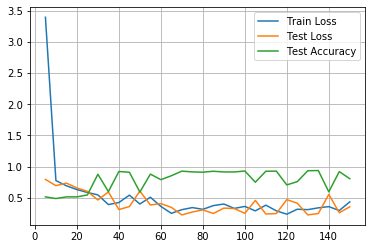

In [11]:
plt.plot(totalsteps, traininglosses, label='Train Loss')
plt.plot(totalsteps, testinglosses, label='Test Loss')
plt.plot(totalsteps, testaccuracy, label='Test Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# checkpoint = {
#     'parameters' : model.parameters,
#     'state_dict' : model.state_dict()
# }


torch.save(checkpoint, './bowlingClassifierDensenet121Accuracy{}.pth'.format(a))

In [12]:
torch.save(model, './resnet50accuracy{}.pth'.format(a))